In [13]:
import pandas as pd


# Define the column names for the dataset
column_names = [
   'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
   'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
   'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
   'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
   'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
   'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
   'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
   'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
   'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
   'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate',
   'class', 'difficulty'
]


# Load the dataset from a CSV file
try:
   training_dataset = pd.read_csv('KDDTrain+.txt', names=column_names, header=None)
   testing_dataset = pd.read_csv('KDDTest+.txt', names=column_names, header=None)
except FileNotFoundError:
   print("Dataset files not found. Please ensure 'KDDTain+.txt' and 'KDDTest+.txt' are in the current directory.")
   exit()


print("Datasets loaded successfully.\n")
print(f"--- Training Dataset Preview ---")
print(f"{training_dataset.head()}")
print(f"Training dataset shape: {training_dataset.shape}")
print(f"Testing dataset shape: {testing_dataset.shape}")


Datasets loaded successfully.

--- Training Dataset Preview ---
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0               0       0    0  ...                    0.17   
1               0       0    0  ...                    0.00   
2               0       0    0  ...                    0.10   
3               0       0    0  ...                    1.00   
4               0       0    0  ...                    1.00   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    0.03                         0.17   
1       

Preprocessing pipeline created successfully!
Numeric columns: 38 | Categorical columns: ['protocol_type', 'service', 'flag']


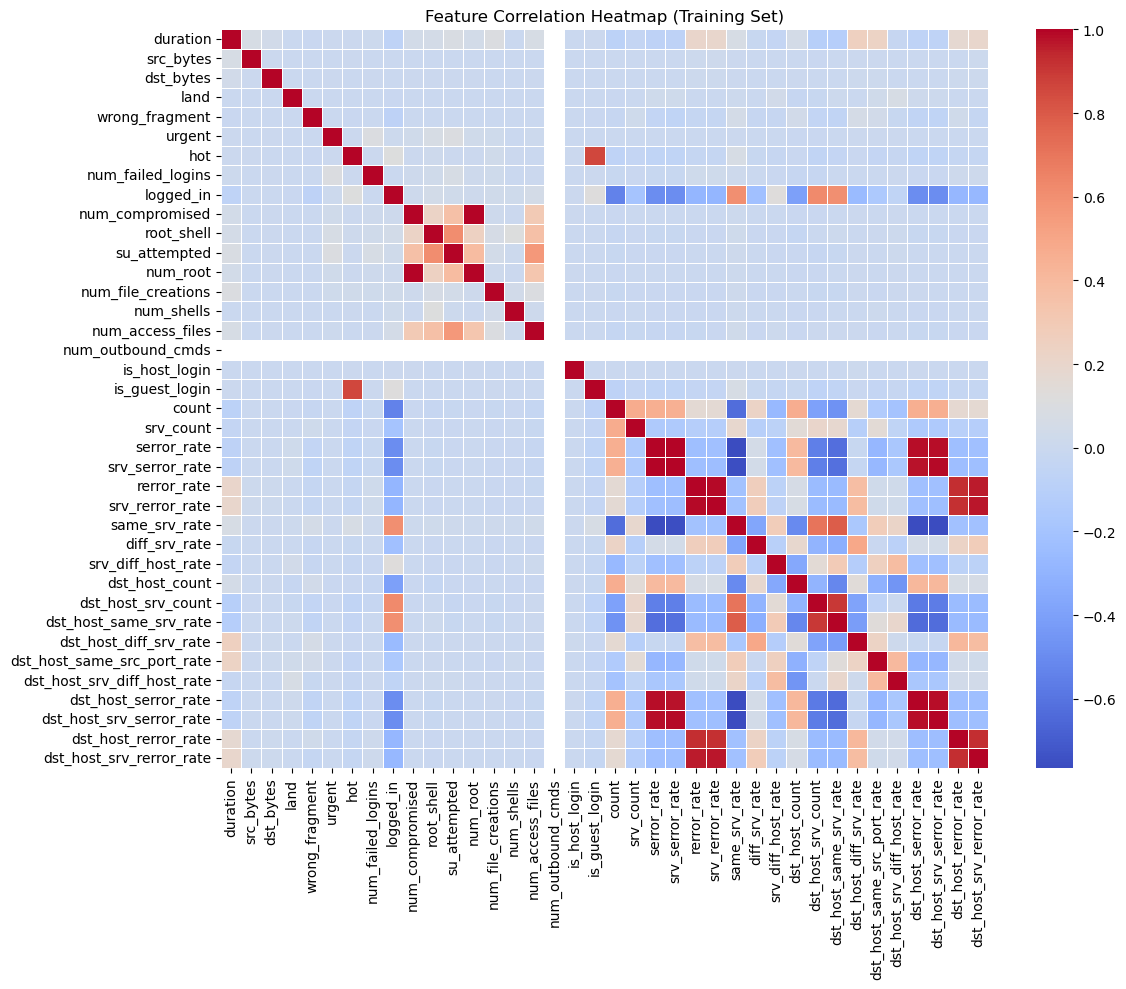

In [ ]:
# Step 2: Data preprocessing and feature engineering
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

CATEGORICAL_COLS = ['protocol_type', 'service', 'flag']
LABEL_COL = 'class'
DIFFICULTY_COL = 'difficulty'

# Convert all attack labels to 'attack' for binary classification
y_train = training_dataset[LABEL_COL].apply(lambda x: 'normal' if x.strip() == 'normal' else 'attack')
y_test  = testing_dataset[LABEL_COL].apply(lambda x: 'normal' if x.strip() == 'normal' else 'attack')

# Drop label and difficulty columns from features
X_train = training_dataset.drop([LABEL_COL, DIFFICULTY_COL], axis=1)
X_test  = testing_dataset.drop([LABEL_COL, DIFFICULTY_COL], axis=1)

# Clean data 
for df in [X_train, X_test]:
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)

# Identify numeric columns
numeric_cols = [c for c in X_train.columns if c not in CATEGORICAL_COLS]

# Build preprocessing pipeline
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(with_mean=False), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), CATEGORICAL_COLS)
    ],
    remainder='drop'
)

print("Preprocessing pipeline created successfully!")
print(f"Numeric columns: {len(numeric_cols)} | Categorical columns: {CATEGORICAL_COLS}")

# Feature Correlation heatmap 
import matplotlib.pyplot as plt
import seaborn as sns


X_train_numeric = X_train.select_dtypes(include=['float64', 'int64'])
corr = X_train_numeric.corr()


# Display heatmap of correlations
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap (Training Set)')
plt.tight_layout()
plt.show()


In [15]:
#Step 3 : Model Training with Logistic Regression 

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import time

print("\n--- Training Logistic Regression Model ---")

# Show training data info
print(f"Training data shape: {X_train.shape}")
print(f"Class distribution:")
print(y_train.value_counts())

# Create pipeline
log_reg_pipeline = Pipeline([
    ('preprocessor', preprocess),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs'))
])

# Train with timing
print("\nTraining in progress...")
start_time = time.time()
log_reg_pipeline.fit(X_train, y_train)
training_time = time.time() - start_time

print(f"Training completed in {training_time:.2f} seconds!")

# Quick training accuracy check
y_train_pred = log_reg_pipeline.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
print(f"Training accuracy: {train_acc:.4f}")




--- Training Logistic Regression Model ---
Training data shape: (125973, 41)
Class distribution:
class
normal    67343
attack    58630
Name: count, dtype: int64

Training in progress...
Training completed in 4.44 seconds!
Training accuracy: 0.9732


In [25]:
# Step 4: Model Prediction

print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

y_test_pred = log_reg_pipeline.predict(X_test)

print("Shape of y_test_pred:", y_test_pred.shape)

print("\nModel prediction on test data complete.")

Shape of X_test: (22544, 41)
Shape of y_test: (22544,)
Shape of y_test_pred: (22544,)

Model prediction on test data complete.



--- Model Evaluation ---
Accuracy:  0.7541
Precision: 0.9176
Recall:    0.6240
F1 Score:  0.7429

--- Classification Report ---
              precision    recall  f1-score   support

      attack       0.92      0.62      0.74     12833
      normal       0.65      0.93      0.76      9711

    accuracy                           0.75     22544
   macro avg       0.78      0.77      0.75     22544
weighted avg       0.80      0.75      0.75     22544



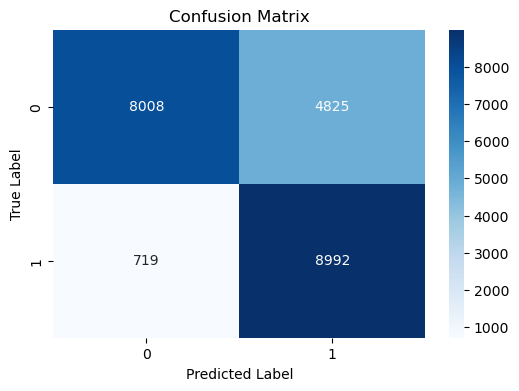

In [26]:
# Step 5: Model Evaluation & Reporting

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

print("\n--- Model Evaluation ---")

# 1. Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, pos_label='attack')
recall = recall_score(y_test, y_test_pred, pos_label='attack')
f1 = f1_score(y_test, y_test_pred, pos_label='attack')

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# 2. Classification report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_test_pred))

# 3. Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()